# **Model and evaluation Notebook 2**

## Objectives

- Fit and evaluate a classification model to predict if a patient will suffer from heart disease or not.
- Fulfil business requirement 2.

## Inputs

* outputs/datasets/cleaned/TargetTestSet.csv
* outputs/datasets/cleaned/TargetTrainSet.csv
* outputs/datasets/cleaned/TestSetCleaned.csv
* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/collection/heart.csv

## Outputs

* Test set (features and target)
* Data cleaning and Feature Engineering , and modeling pipeline
* Heatmap for confusion matrix report plot



---

# Set up the Working Directory

Define and confirm the working directory.

In [1]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspaces/heart-disease-analysis-and-prediction'

---

# Load data

In [2]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/heart.csv"))

# Separate predictors and target
X = df.drop(['target'], axis=1)
y = df['target']

print(X.shape)
X.head(3)

(1025, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3


### Loading clean train and test set

In [3]:
import numpy as np
import pandas as pd

y_test = (pd.read_csv("outputs/datasets/cleaned/TargetTestSet.csv"))
y_train = (pd.read_csv("outputs/datasets/cleaned/TargetTrainSet.csv"))
X_test = (pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv"))
X_train = (pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv"))

An error was found , for the y_train and y_test being a 2d array

In [4]:
y_train.head(2)

,target
0,1
1,1


Used ravel to make both of them a 1d array

In [5]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Finding the best combination of features

The following are the two combination of features study and found in previous notebooks:

- best_features = From ModelAndEvaluation notebook, found with feature importance.
- best_correlation_features = From FeatureSelection notebook, found with correlational study.

In [6]:
best_features = ['ca', 'cp', 'thal']
best_features

['ca', 'cp', 'thal']

In [7]:
best_correlation_features = ['cp', 'chol', 'thalach','exang', 'oldpeak', 'ca']
best_correlation_features

['cp', 'chol', 'thalach', 'exang', 'oldpeak', 'ca']

Trying to use all use all features in the two combination of features. Difference was just adding thal to best_correlation_features.

In [8]:
features_selected = ['cp', 'chol', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']

In [9]:
X_train_filtered = X_train.filter(features_selected)
X_test_filtered = X_test.filter(features_selected)

print(X_train_filtered.shape, y_train.shape, X_test_filtered.shape, y_test.shape)
X_train_filtered.head(3)

(301, 7) (301,) (161, 7) (161,)


,cp,chol,thalach,exang,oldpeak,ca,thal
0,3,244,178,0,0.8,2,2
1,2,278,152,0,0.0,1,2
2,2,246,173,0,0.0,3,2


# Reaxamine performance of the pipeline

Loading pipeline from " ModelAndEvaluation notebook " section "We create a new pipeline, using the best model and the best hyperparameters from the research above."

We know that the following pipeline has the best model and the best hyperparameters

In [10]:
from xgboost import XGBClassifier
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

def xgbclassifier_pipeline():
    # Define the hyperparameters
    hyperparameters = {
        'learning_rate': 0.01,
        'max_depth': 3,
        'n_estimators': 100
    }

    model = XGBClassifier(**hyperparameters, random_state=0)

    pipeline_base = Pipeline([
        ("YeoJohnsonTransformer", YeoJohnsonTransformer(variables=['cp', 'chol','thalach', 'exang', 'oldpeak', 'ca', 'thal'])),
        ("scaler", StandardScaler()),
        ('model', model)
    ])

    return pipeline_base

# Create the XGBoost pipeline with hyperparameters
xgb_pipeline = xgbclassifier_pipeline()
xgb_pipeline.fit(X_train_filtered, y_train)

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['cp', 'chol', 'thalach',
                                                  'exang', 'oldpeak', 'ca',
                                                  'thal'])),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_me...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

Check feature importance after fitting data.

In [11]:
# Fit the XGBoost pipeline
xgb_pipeline.fit(X_train_filtered, y_train)

model = xgb_pipeline.named_steps['model']

feature_importances = model.feature_importances_

feature_names = xgb_pipeline.named_steps['YeoJohnsonTransformer'].variables + ['scaler']  # Add 'scaler' for scaled features

feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, feature_importances)}

sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_feature_importance)


{'cp': 0.36343855, 'thal': 0.21138917, 'ca': 0.14942652, 'exang': 0.10546639, 'oldpeak': 0.06979592, 'thalach': 0.056436583, 'chol': 0.044046886}


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train_filtered, y_train, X_test_filtered, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train_filtered, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test_filtered, y_test, pipeline, label_map)

In [33]:
print(classification_report(y_pred=xgb_pipeline.predict(X_train_filtered), y_true=y_train))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       137
           1       0.83      0.95      0.89       164

    accuracy                           0.87       301
   macro avg       0.88      0.86      0.86       301
weighted avg       0.88      0.87      0.87       301



In [13]:
print(classification_report(y_pred=xgb_pipeline.predict(X_test_filtered), y_true=y_test))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88        75
           1       0.86      0.98      0.91        86

    accuracy                           0.90       161
   macro avg       0.91      0.90      0.90       161
weighted avg       0.91      0.90      0.90       161



Heatmap for classification report

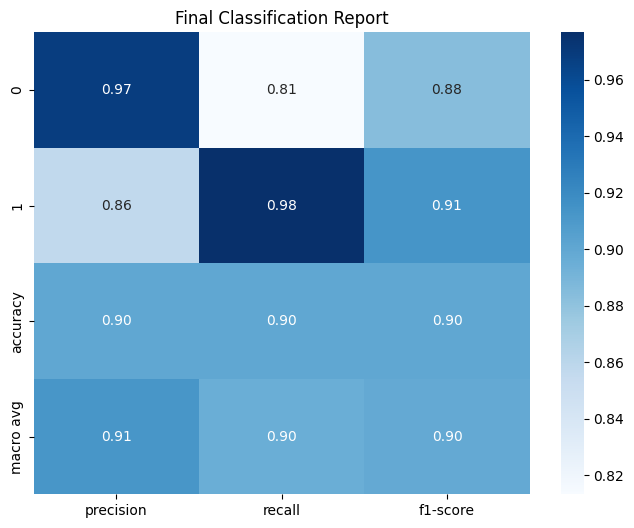

In [14]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
report = classification_report(y_pred=xgb_pipeline.predict(X_test_filtered), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Final Classification Report')

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'
# Define the filename for this plot
plot_filename_classification_report_1 = f'{file_path}/classification_report_3.png'

plt.show()

Combination of features actually perform better than previous one reaching accuracy of 0.90:

- **the precision for class 0 is 0.97**
- the precision for class 1 is 0.86
- the recall for class 0 is 0.81
- **the recall for class 1 is 0.98**
- **accuracy of 0.90**

Developer chose this as the best combination of features .

---

# Save and push file to repo

We will generate the following files:

- Train set
- Test set
- Data cleaning and Feature Engineering , and modeling pipeline
- Heatmap plot for confusion matrix report

In [15]:
import os

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_heart_disease/v3'


## Train Set

In [16]:
print(X_train.shape)
X_train.head()

(301, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,42,1,3,148,244,0,0,178,0,0.8,2,2,2
1,66,0,2,146,278,0,0,152,0,0.0,1,1,2
2,53,1,2,130,246,1,0,173,0,0.0,2,3,2
3,58,0,0,100,248,0,0,122,0,1.0,1,0,2
4,53,1,0,123,282,0,1,95,1,2.0,1,2,3


In [17]:
X_train = X_train_filtered
X_test = X_test_filtered

X_train.head(3)

,cp,chol,thalach,exang,oldpeak,ca,thal
0,3,244,178,0,0.8,2,2
1,2,278,152,0,0.0,1,2
2,2,246,173,0,0.0,3,2


In [18]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

Retransforming y to dataframe

In [19]:
import pandas as pd

y_train = pd.DataFrame({'target': y_train})

In [20]:
y_train.head()

,target
0,1
1,1
2,1
3,1
4,0


In [21]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test set

In [22]:
print(X_test.shape)
X_test.head()

(161, 7)


,cp,chol,thalach,exang,oldpeak,ca,thal
0,2,233,179,1,0.4,0,2
1,1,319,152,0,0.0,2,2
2,0,187,144,1,4.0,2,3
3,2,211,165,0,0.0,0,2
4,0,260,140,1,3.6,1,3


In [23]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

Retransforming y to dataframe

In [24]:
y_test = pd.DataFrame({'target' : y_test})

In [25]:
y_test.head()

,target
0,1
1,0
2,0
3,1
4,0


In [26]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Save pipeline

In [27]:
xgbclassifier_pipeline = xgb_pipeline
xgbclassifier_pipeline

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['cp', 'chol', 'thalach',
                                                  'exang', 'oldpeak', 'ca',
                                                  'thal'])),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_me...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [28]:
import joblib

joblib.dump(xgbclassifier_pipeline, f"{file_path}/xgbclassifier_pipeline.pkl")

['outputs/ml_pipeline/predict_heart_disease/v3/xgbclassifier_pipeline.pkl']

## Save heatmap report on performance

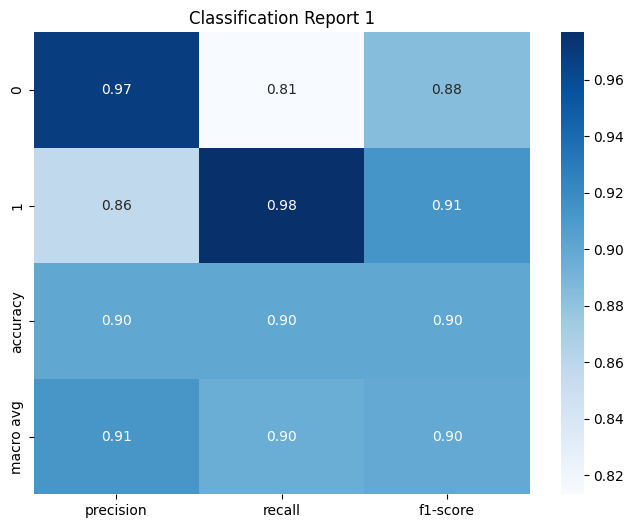

In [29]:
# Generate classification report
report = classification_report(y_pred=xgb_pipeline.predict(X_test_filtered), y_true=y_test, output_dict=True)

# Convert the classification report to a DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot the classification report using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_report.iloc[:-1, :3], annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report 1')

# Save the plot to the specified filename
plt.savefig(plot_filename_classification_report_1, bbox_inches='tight')

# Display the saved plot
plt.show()